# Interpreting Morgan Fingerprint Bits Over a Complete Dataset

It is already very easy to display the encoded substructures of a Morgan Fingeprint bit for a specific molecule. However, if you train a machine learning model, for example a random forest, using Morgan fingerprints and look at the most important bits (feature importance), it is not sufficient to look at the substructure of this bit for a specific molecule. Due to collisions during fingerprint folding, it can happen that several substructures are encoded in one Morgan bit. For this, the analysis needs to be extended to all molecules.

This notebook attempts to illustrate this scenario and give an overview of the most important substructures of any bit for an example random forest model.

**Author:** Marcel Baltruschat ([@GitHub](https://github.com/mrcblt))<br>
**Date:** 31.10.2022<br>
**License:** MIT

---

## Preparation

In [1]:
# Import everything necessary
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools, Draw, DataStructs
from rdkit.Chem.Draw import IPythonConsole

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize

from ipywidgets import interact
from ipywidgets.widgets import BoundedIntText
from IPython.display import SVG

In [2]:
# Adjust rendering settings
IPythonConsole.molSize = 300,300
IPythonConsole.ipython_useSVG = True

PandasTools.RenderImagesInAllDataFrames()

7292


,SMILES,pIC50,ROMol
ChEMBL_ID,,,
CHEMBL1000,O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1,4.515,
CHEMBL100415,CCCCN(Cc1cncn1Cc1ccc(C#N)cc1)[C@H]1CCN(Cc2cccc...,6.720,

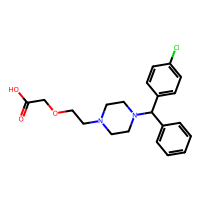
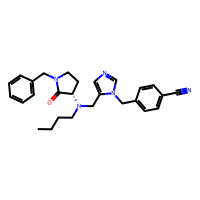

In [3]:
# Load an example hERG dataset [1]
df = pd.read_csv('https://raw.githubusercontent.com/czodrowskilab/5minfame/main/datasets/hERG_exact_IC50_ChEMBL31.csv',
                 sep=';', usecols=['Molecule ChEMBL ID', 'Smiles', 'pChEMBL Value'])
df.columns = ['ChEMBL_ID', 'SMILES', 'pIC50']
df.dropna(subset=['pIC50'], inplace=True)

# Group by ChEMBL ID and average pIC50 values
grp = df.groupby('ChEMBL_ID')
df = grp.first()
df.pIC50 = grp['pIC50'].mean()

PandasTools.AddMoleculeColumnToFrame(df, smilesCol='SMILES')

print(len(df))
df.head(2)

---
## Fingerprints and bit info

In [4]:
# Fingeprint settings
n_bits = 2**12
use_features = False
radius = 2

n_bits

4096

In [5]:
# Calculate fingerprints and the corresponding bit info dictionaries
bi_list = []
fps = np.ndarray(shape=(len(df), n_bits), dtype=np.uint8)
for i, mol in enumerate(df.ROMol):
    bi = {}
    fp = Chem.GetMorganFingerprintAsBitVect(mol, radius, bitInfo=bi, nBits=n_bits, useFeatures=use_features)
    DataStructs.ConvertToNumpyArray(fp, fps[i])
    bi_list.append(bi)

In [6]:
# Showing content of an example bit info dictionary
bi_list[0]

{13: ((5, 1),),
 15: ((11, 2),),
 216: ((21, 1),),
 389: ((15, 2),),
 561: ((22, 1),),
 695: ((4, 0),),
 807: ((2, 0),),
 1088: ((14, 1), (15, 1), (16, 1)),
 1145: ((6, 1),),
 1265: ((10, 1),),
 1275: ((4, 2),),
 1364: ((10, 2),),
 1365: ((12, 1), (18, 1)),
 1380: ((12, 0), (18, 0), (21, 0)),
 1480: ((8, 1), (9, 1), (25, 1), (26, 1)),
 1627: ((9, 2), (25, 2)),
 1683: ((22, 0),),
 1737: ((1, 1),),
 1917: ((0, 1),),
 2004: ((3, 1),),
 2049: ((11, 0),),
 2107: ((3, 2),),
 2122: ((8, 2), (26, 2)),
 2128: ((3, 0), (5, 0), (6, 0)),
 2437: ((2, 1),),
 2509: ((11, 1),),
 2581: ((6, 2),),
 2698: ((0, 0),),
 2701: ((5, 2),),
 2732: ((1, 2),),
 2855: ((1, 0),),
 2864: ((20, 2), (23, 2)),
 2974: ((8, 0), (9, 0), (25, 0), (26, 0)),
 2983: ((7, 0), (10, 0)),
 3118: ((21, 2),),
 3247: ((14, 2), (16, 2)),
 3369: ((12, 2), (18, 2)),
 3530: ((7, 2),),
 3629: ((13, 2), (17, 2)),
 3798: ((13, 1), (19, 1), (20, 1), (23, 1), (17, 1), (24, 1)),
 3839: ((7, 1),),
 3901: ((19, 2), (24, 2)),
 3921: ((13, 0),
  

<u>Explanation:</u> **"The dictionary provided is populated with one entry per bit set in the fingerprint, the keys are the bit ids, the values are lists of (atom index, radius) tuples."** [2]

---
## Looking into a single bit of two molecules

In [7]:
# Molecules of choice
mol1_ix = 0  # CHEMBL1000
mol2_ix = 1  # CHEMBL100415

In [8]:
# Bits that the two molecules have in common
overlap = bi_list[mol1_ix].keys() & bi_list[mol2_ix].keys()
overlap

{389, 1088, 1380, 1480, 2128, 2698, 2974, 2983, 3247, 3798, 3921}

In [9]:
# Bit of interest
bit_oi = overlap.pop()
bit_oi

1088

In [10]:
# First molecule
print(bi_list[mol1_ix][bit_oi])
print(f'=> {len(bi_list[mol1_ix][bit_oi])} matches in first molecule of substructure(s) encoded in selected bit')

((14, 1), (15, 1), (16, 1))
=> 3 matches in first molecule of substructure(s) encoded in selected bit


In [11]:
# Second molecule
print(bi_list[mol2_ix][bit_oi])
print(f'=> {len(bi_list[mol2_ix][bit_oi])} matches in second molecule of substructure(s) encoded in selected bit')

((27, 1), (28, 1), (29, 1))
=> 3 matches in second molecule of substructure(s) encoded in selected bit


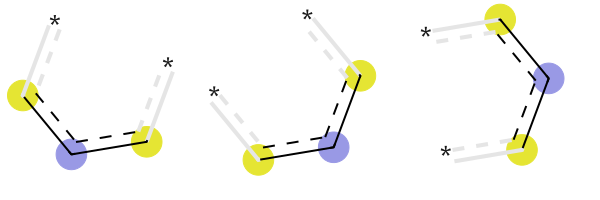

In [12]:
# Environments of first molecule 
Draw.DrawMorganBits([(df.loc[df.index[mol1_ix], 'ROMol'], bit_oi, bi_list[mol1_ix], i) for i in range(len(bi_list[mol1_ix][bit_oi]))],
                    subImgSize=(200, 200))

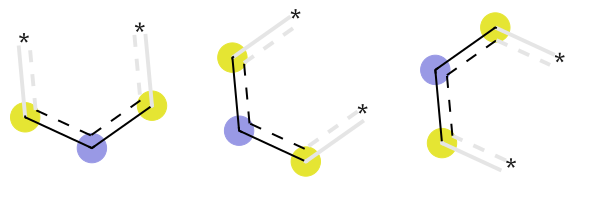

In [13]:
# Environments of second molecule 
Draw.DrawMorganBits([(df.loc[df.index[mol2_ix], 'ROMol'], bit_oi, bi_list[mol2_ix], i) for i in range(len(bi_list[mol2_ix][bit_oi]))],
                    subImgSize=(200, 200))

---
## Training an example model

In [14]:
random_state = 42

In [15]:
# Prepare data
x_all = fps
y_all = binarize(df.pIC50.values.reshape(-1, 1), threshold=6.0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, 
                                                    random_state=random_state, stratify=y_all)

In [16]:
model = RandomForestClassifier(random_state=random_state, n_jobs=4)
model.fit(x_train, y_train.ravel())
print(f'Kappa: {cohen_kappa_score(model.predict(x_test), y_test):.2f}')

Kappa: 0.50


In [17]:
feat_imp = pd.DataFrame(dict(bits=range(n_bits), importance=model.feature_importances_)).sort_values(by='importance', ascending=False).set_index('bits')
feat_imp.head(5)

,importance
bits,
1928,0.003878
2855,0.003815
3839,0.003811
3247,0.003764
2698,0.003575


---
## Gather information for all bits set over the whole dataset

In [18]:
subs_per_onbits = defaultdict(list)
for i, (_, row) in enumerate(df.iterrows()):
    mol = row.ROMol
    bi = bi_list[i]
    for bit in bi:
        for aix, r in bi[bit]:
            subs_per_onbits[bit].append((mol, aix, r))
print(f'{len(subs_per_onbits.keys())} / {n_bits} bits are set for at least one molecule')

4081 / 4096 bits are set for at least one molecule


## Filtering duplicates per bit and extract fragment SMARTS

In [19]:
spo_filtered = defaultdict(list)
frags = defaultdict(list)

for bit in subs_per_onbits:
    seen = []
    for mol, aix, r in subs_per_onbits[bit]:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, r, aix, useHs=True)
        atoms = {aix}
        for bidx in env:
            atoms.add(mol.GetBondWithIdx(bidx).GetBeginAtomIdx())
            atoms.add(mol.GetBondWithIdx(bidx).GetEndAtomIdx())
        smi = Chem.MolFragmentToSmiles(mol, atomsToUse=list(atoms), bondsToUse=env, rootedAtAtom=aix)
        if smi not in seen:
            spo_filtered[bit].append((mol, aix, r))
            seen.append(smi)
    frags[bit] = seen
spo_filtered = dict(spo_filtered)

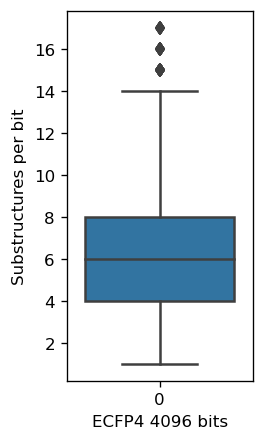

In [20]:
plt.figure(figsize=(2, 4), dpi=120)
fig = sns.boxplot([len(frags[bit]) for bit in frags])
fig.set_ylabel('Substructures per bit')
_ = fig.set_xlabel(f'{"F" if use_features else "E"}CFP{radius * 2} {n_bits} bits')

## Interactive Part

In [21]:
# Settings
sort_by_importance = True
drop_down = True  # If False, bit number can be entered manually

In [22]:
if sort_by_importance:
    choices = [bit for bit in feat_imp.index if bit in spo_filtered]
else:
    choices = sorted(spo_filtered.keys())

In [23]:
def renderBitEnvs(bit):
    if bit in spo_filtered:
        return SVG(Draw.DrawMorganEnvs(spo_filtered[bit], legends=frags[bit], subImgSize=(300, 200), molsPerRow=4))
    return 'Bit not set!'

inp = choices if drop_down else BoundedIntText(value=choices[0],
                                               min=min(choices),
                                               max=max(choices))
_ = interact(renderBitEnvs, bit=inp)

interactive(children=(Dropdown(description='bit', options=(1928, 2855, 3839, 3247, 2698, 1535, 1088, 1917, 875…

**Some notes about the rendering here[3]:**
- The molecule fragment is drawn with the atoms in the same positions as in the original molecule.
- The central atom is highlighted in blue.
- Aromatic atoms are highlighted in yellow
- Aliphatic ring atoms (none present here) are highlighted in dark gray
- Atoms/bonds that are drawn in light gray indicate pieces of the structure that influence the atoms' connectivity invariants but that are not directly part of the fingerprint.

## References
[1] https://github.com/czodrowskilab/5minfame<br>
[2] https://www.rdkit.org/docs/GettingStartedInPython.html#explaining-bits-from-morgan-fingerprints<br>
[3] https://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html

## Useful resources
- https://iwatobipen.wordpress.com/2018/11/07/visualize-important-features-of-machine-leaning-rdkit/
- https://github.com/rdkit/rdkit/discussions/4688
- https://sourceforge.net/p/rdkit/mailman/message/36438523/